In [57]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error
from xgboost import XGBRegressor
import warnings
warnings.filterwarnings('ignore')

In [58]:
url = "https://archive.ics.uci.edu/ml/machine-learning-databases/forest-fires/forestfires.csv"
df = pd.read_csv(url)
df.head()

,X,Y,month,day,FFMC,DMC,DC,ISI,temp,RH,wind,rain,area
0,7,5,mar,fri,86.2,26.2,94.3,5.1,8.2,51,6.7,0.0,0.0
1,7,4,oct,tue,90.6,35.4,669.1,6.7,18.0,33,0.9,0.0,0.0
2,7,4,oct,sat,90.6,43.7,686.9,6.7,14.6,33,1.3,0.0,0.0
3,8,6,mar,fri,91.7,33.3,77.5,9.0,8.3,97,4.0,0.2,0.0
4,8,6,mar,sun,89.3,51.3,102.2,9.6,11.4,99,1.8,0.0,0.0


Dataset Shape: (517, 13)

Data Types:
 X          int64
Y          int64
month     object
day       object
FFMC     float64
DMC      float64
DC       float64
ISI      float64
temp     float64
RH         int64
wind     float64
rain     float64
area     float64
dtype: object

Missing Values:
 X        0
Y        0
month    0
day      0
FFMC     0
DMC      0
DC       0
ISI      0
temp     0
RH       0
wind     0
rain     0
area     0
dtype: int64

Data Types after conversion:
 X          int64
Y          int64
month      int64
day        int64
FFMC     float64
DMC      float64
DC       float64
ISI      float64
temp     float64
RH         int64
wind     float64
rain     float64
area     float64
dtype: object

Descriptive Statistics:
                 X           Y       month         day        FFMC         DMC  \
count  517.000000  517.000000  517.000000  517.000000  517.000000  517.000000   
mean     4.669246    4.299807    7.475822    4.259188   90.644681  110.872340   
std      2.313778

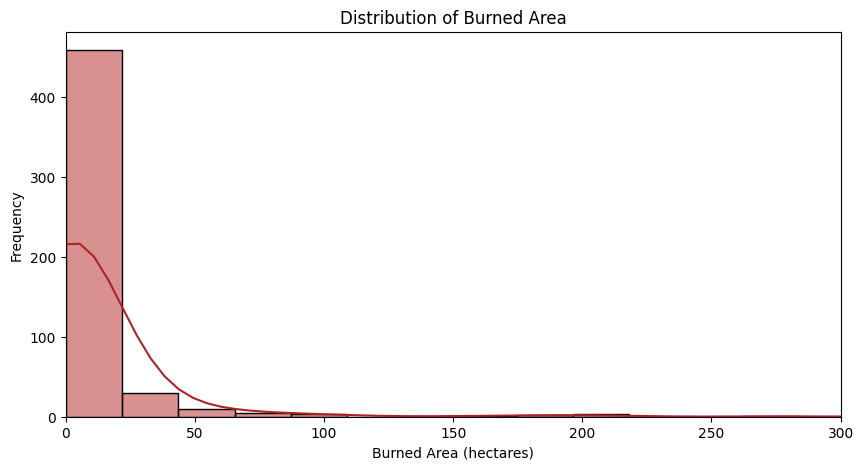

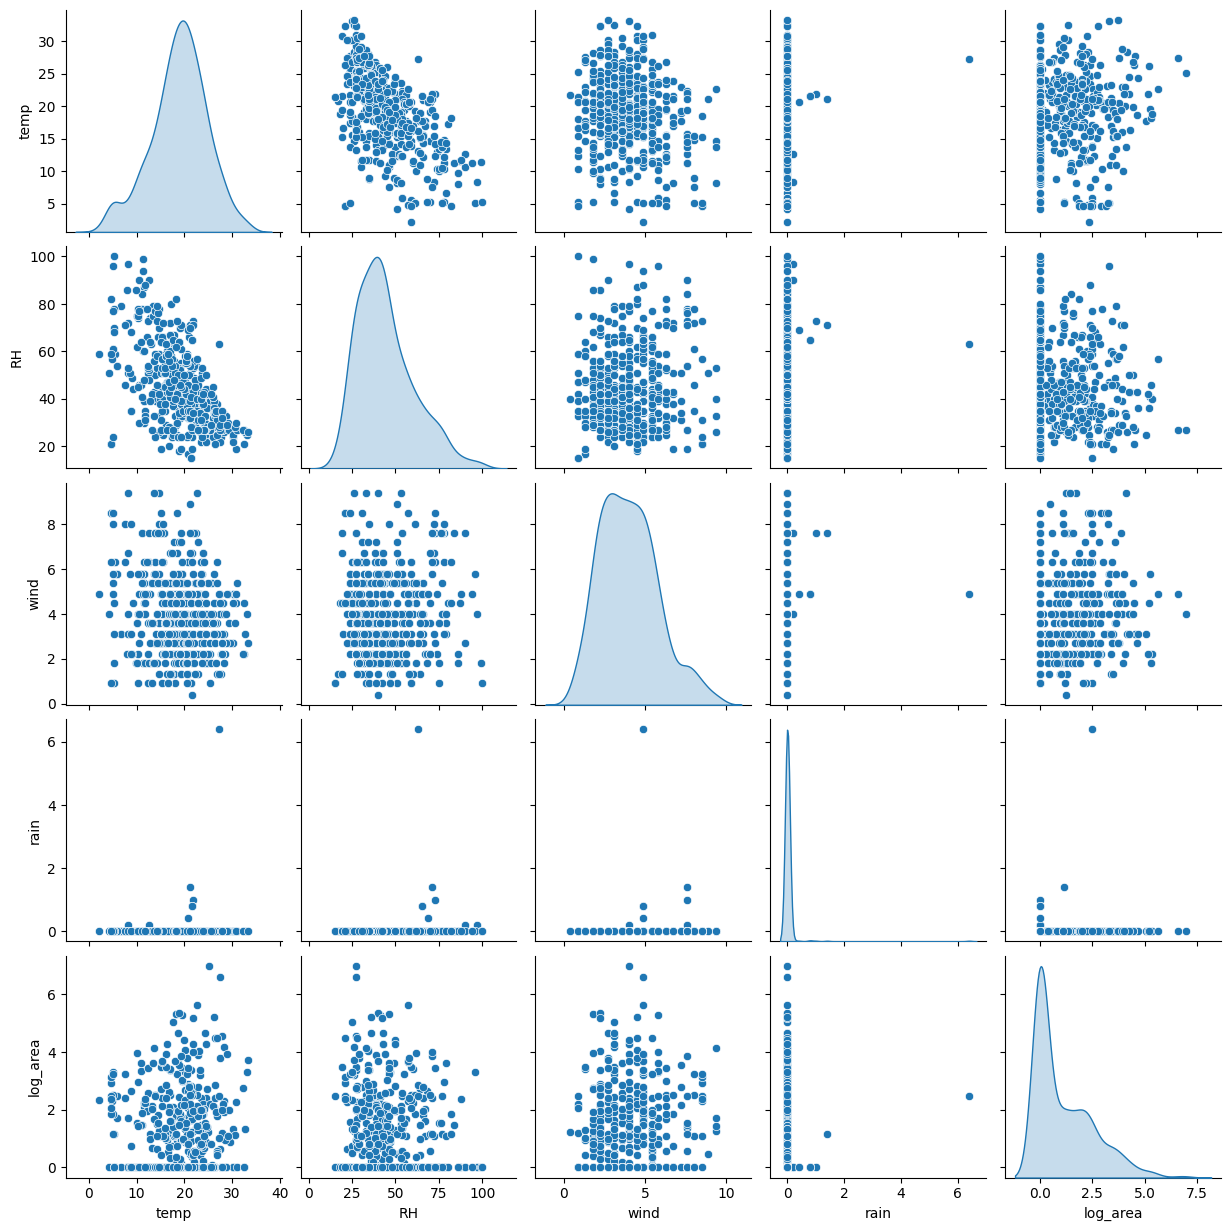

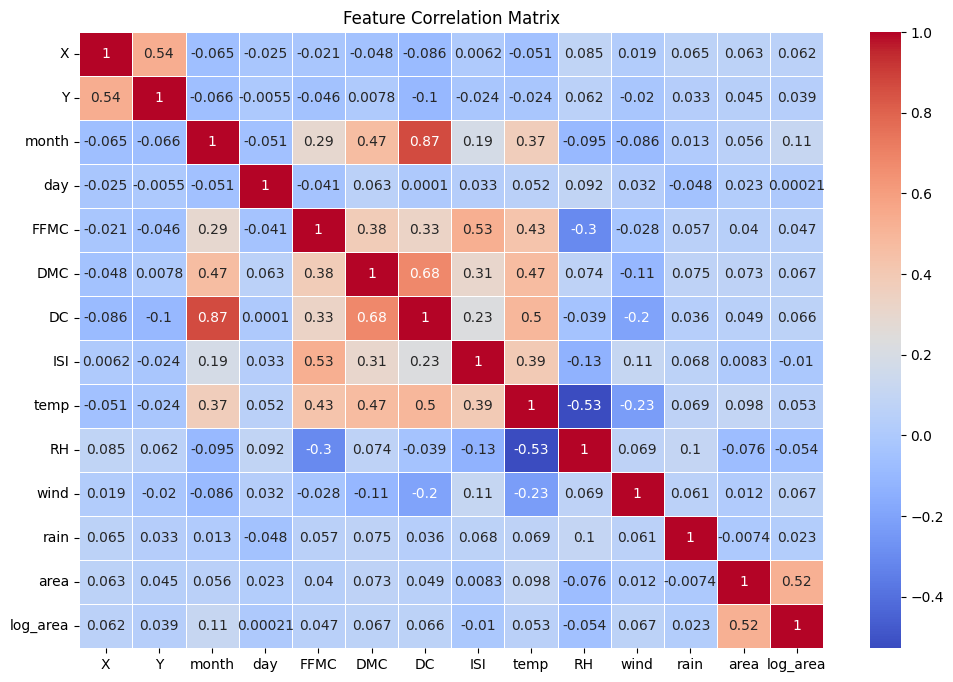

In [59]:
print("Dataset Shape:", df.shape)
print("\nData Types:\n", df.dtypes)
print("\nMissing Values:\n", df.isnull().sum())


month_mapping = {'jan':1, 'feb':2, 'mar':3, 'apr':4, 'may':5, 'jun':6,
                 'jul':7, 'aug':8, 'sep':9, 'oct':10, 'nov':11, 'dec':12}
day_mapping = {'mon':1, 'tue':2, 'wed':3, 'thu':4, 'fri':5, 'sat':6, 'sun':7}

df['month'] = df['month'].map(month_mapping)
df['day'] = df['day'].map(day_mapping)


cols_to_numeric = ['temp', 'RH', 'wind', 'rain', 'area']
for col in cols_to_numeric:
    df[col] = pd.to_numeric(df[col], errors='coerce')


print("\nData Types after conversion:\n", df.dtypes)


print("\nDescriptive Statistics:\n", df.describe())

plt.figure(figsize=(10,5))
sns.histplot(df['area'], bins=50, kde=True, color='firebrick')
plt.title('Distribution of Burned Area')
plt.xlabel('Burned Area (hectares)')
plt.ylabel('Frequency')
plt.xlim(0, 300)
plt.show()


df['log_area'] = np.log1p(df['area'])


sns.pairplot(df[['temp', 'RH', 'wind', 'rain', 'log_area']], diag_kind='kde')
plt.show()


plt.figure(figsize=(12,8))
sns.heatmap(df.corr(), annot=True, cmap='coolwarm', linewidths=0.5)
plt.title('Feature Correlation Matrix')
plt.show()


In [60]:
df['log_area'] = np.log1p(df['area'])
df['temp_RH'] = df['temp'] * df['RH']
df['temp_wind'] = df['temp'] * df['wind']
df['rain_wind'] = df['rain'] * df['wind']
df['temp_squared'] = df['temp'] ** 2
df['RH_squared'] = df['RH'] ** 2
df['wind_squared'] = df['wind'] ** 2
df['month_sin'] = np.sin(2 * np.pi * df['month']/12)
df['month_cos'] = np.cos(2 * np.pi * df['month']/12)
df['day_sin'] = np.sin(2 * np.pi * df['day']/7)
df['day_cos'] = np.cos(2 * np.pi * df['day']/7)
print("New Features Added Successfully! 🚀")

New Features Added Successfully! 🚀


In [61]:
X = df.drop(['area', 'log_area'], axis=1)
y = df['log_area']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [62]:
xgb = XGBRegressor(random_state=42)

# Hyperparameter Grid
param_dist = {
    'n_estimators': [100, 200, 300, 500],
    'learning_rate': [0.01, 0.05, 0.1, 0.2],
    'max_depth': [3, 5, 7, 10],
    'subsample': [0.6, 0.7, 0.8, 0.9],
    'colsample_bytree': [0.6, 0.7, 0.8, 0.9],
}

# Randomized Search
random_search = RandomizedSearchCV(
    estimator=xgb,
    param_distributions=param_dist,
    n_iter=30,
    scoring='neg_mean_squared_error',
    cv=3,
    verbose=2,
    random_state=42,
    n_jobs=-1
)


random_search.fit(X_train_scaled, y_train)

best_xgb = random_search.best_estimator_

y_pred = best_xgb.predict(X_test_scaled)


rmse = np.sqrt(mean_squared_error(y_test, y_pred))
print(f"Best RMSE after Tuning: {rmse:.4f}")

Fitting 3 folds for each of 30 candidates, totalling 90 fits
Best RMSE after Tuning: 1.4568


In [63]:
best_model = random_search.best_estimator_


y_pred = best_model.predict(X_test_scaled)


rmse = np.sqrt(mean_squared_error(y_test, y_pred))
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"RMSE: {rmse:.4f}")
print(f"MAE: {mae:.4f}")
print(f"R² Score: {r2:.4f}")

RMSE: 1.4568
MAE: 1.1753
R² Score: 0.0344


In [64]:
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor


rf_model = RandomForestRegressor(random_state=42, n_jobs=-1)
rf_model.fit(X_train_scaled, y_train)
rf_pred = rf_model.predict(X_test_scaled)

rf_rmse = np.sqrt(mean_squared_error(y_test, rf_pred))
print(f"Random Forest RMSE: {rf_rmse:.2f}")


gb_model = GradientBoostingRegressor(random_state=42)
gb_model.fit(X_train_scaled, y_train)
gb_pred = gb_model.predict(X_test_scaled)


gb_rmse = np.sqrt(mean_squared_error(y_test, gb_pred))
print(f"Gradient Boosting RMSE: {gb_rmse:.2f}")

Random Forest RMSE: 1.47
Gradient Boosting RMSE: 1.49


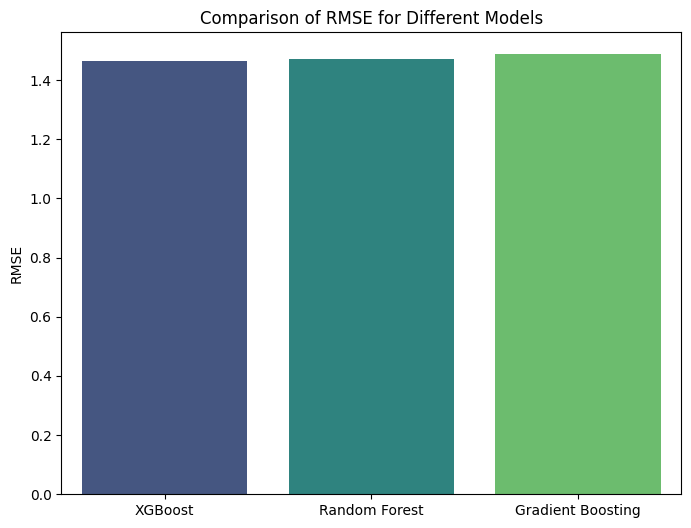

In [65]:
import matplotlib.pyplot as plt
import seaborn as sns


models = ['XGBoost', 'Random Forest', 'Gradient Boosting']
rmse_values = [rmse_xgb, rf_rmse, gb_rmse]


plt.figure(figsize=(8, 6))
sns.barplot(x=models, y=rmse_values, palette='viridis')
plt.title('Comparison of RMSE for Different Models')
plt.ylabel('RMSE')
plt.show()

In [55]:
import pickle
with open('/content/best_xgb_model.pkl', 'wb') as f:
    pickle.dump(best_xgb, f)

In [56]:
from google.colab import files

# Download the saved model file
files.download('/content/best_xgb_model.pkl')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>